In [2]:
import pyTMD
import numpy as np

import pyTMD.io
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import timescale.time

import matplotlib.pyplot as plt

In [3]:
# available model list
model_list = sorted(pyTMD.io.model.ocean_elevation())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'GOT4.10_nc'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.compress,
    TMDwidgets.datepick
])

In [4]:
# default coordinates to use
LAT,LON = (-77.777664,167.868027)
m = pyTMD.tools.leaflet(center=(LAT,LON), zoom=7,
    zoom_control=True, marker_control=True,
    attribution=False)
# show map
m.map

Map(center=[-77.777664, 167.868027], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

TypeError: interpolate_constants() takes 3 positional arguments but 4 were given

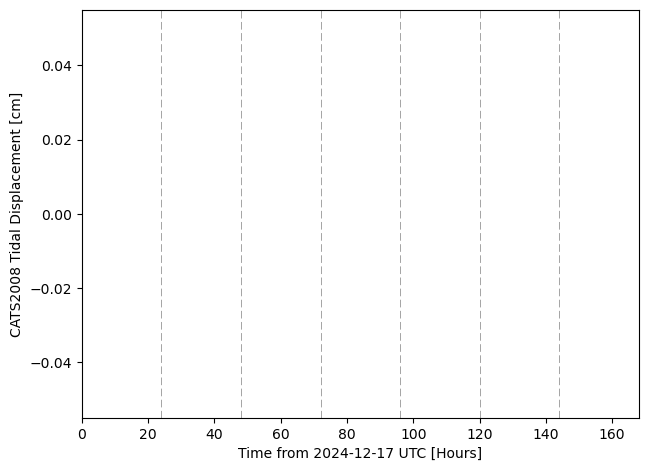

In [6]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
# calculate a weeks forecast every minute
minutes = np.arange(7*1440)
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
ts = timescale.from_calendar(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
xmax = np.ceil(hours[-1]).astype('i')
l1, = ax1.plot([], [], 'k')
l2, = ax1.plot([], [], 'r*')
l3, = ax1.plot([], [], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)
ax1.set_ylabel(f'{model.name} Tidal Displacement [cm]')
args = (YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ttl = ax1.set_title(None)
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.10,top=0.95)

# read tidal constants and interpolate to leaflet points
if model.format in ('OTIS','ATLAS-compact','TMD3'):
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file, model.model_file,
        model.projection, type=model.type,
        grid=model.file_format)
    c = constituents.fields
    DELTAT = np.zeros_like(ts.tide)
elif (model.format == 'ATLAS-netcdf'):
    constituents = pyTMD.io.ATLAS.read_constants(
        model.grid_file, model.model_file,
        type=model.type, compressed=model.compressed)
    c = constituents.fields
    DELTAT = np.zeros_like(ts.tide)
elif model.format in ('GOT-ascii', 'GOT-netcdf'):
    constituents = pyTMD.io.GOT.read_constants(
        model.model_file, grid=model.file_format,
        compressed=model.compressed)
    c = constituents.fields
    # delta time (TT - UT1)
    DELTAT = ts.tt_ut1
elif (model.format == 'FES-netcdf'):
    constituents = pyTMD.io.FES.read_constants(model.model_file,
        type=model.type, version=model.version,
        compressed=model.compressed)
    c = model.constituents
    # delta time (TT - UT1)
    DELTAT = ts.tt_ut1

# update the tide prediction and plot
def update_tide_prediction(*args):
    # leaflet location
    LAT,LON = np.copy(m.marker.location)
    # verify longitudes
    LON = m.wrap_longitudes(LON)
    if model.format in ('OTIS','ATLAS-compact','TMD3'):
        amp,ph,D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, model.projection, type=model.type,
            method='spline', extrapolate=True)
    elif (model.format == 'ATLAS-netcdf'):
        amp,ph,D = pyTMD.io.ATLAS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, type=model.type, scale=model.scale,
            method='spline', extrapolate=True)
    elif model.format in ('GOT-ascii', 'GOT-netcdf'):
        amp,ph = pyTMD.io.GOT.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'FES-netcdf'):
        amp,ph = pyTMD.io.FES.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)
    # predict tidal elevations at time and infer minor corrections
    TIDE = pyTMD.predict.time_series(ts.tide, hc, c,
        deltat=DELTAT, corrections=model.corrections)
    MINOR = pyTMD.predict.infer_minor(ts.tide, hc, c,
        deltat=DELTAT, corrections=model.corrections)
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    # differentiate to calculate high and low tides
    diff = np.zeros_like(ts.tide, dtype=np.float64)
    # forward differentiation for starting point
    diff[0] = TIDE.data[1] - TIDE.data[0]
    # backward differentiation for end point
    diff[-1] = TIDE.data[-1] - TIDE.data[-2]
    # centered differentiation for all others
    diff[1:-1] = (TIDE.data[2:] - TIDE.data[0:-2])/2.0
    # indices of high and low tides
    htindex, = np.nonzero((np.sign(diff[0:-1]) >= 0) & (np.sign(diff[1:]) < 0))
    ltindex, = np.nonzero((np.sign(diff[0:-1]) <= 0) & (np.sign(diff[1:]) > 0))
    # update plot data
    l1.set_data(hours, TIDE.data)
    l2.set_data(hours[htindex], TIDE.data[htindex])
    l3.set_data(hours[ltindex], TIDE.data[ltindex])
    # update plot title
    ttl.set_text(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0E'.format(LAT,LON))
    ax1.relim()
    ax1.autoscale_view()
    fig.canvas.draw()

    return TIDE, hours

# run tide prediction at initial location
TIDE, hours = update_tide_prediction()
# watch marker location for changes
m.marker_text.observe(update_tide_prediction)

In [8]:
TIDE.data

array([-60.26205228, -60.37882125, -60.49464065, ..., -16.96583695,
       -16.96874445, -16.97128683], shape=(10080,))